In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
import os
import shutil
%matplotlib inline

In [2]:
torch.__version__

'2.1.0+cu121'

In [3]:
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using GPU: %s' % torch.cuda.is_available())

Using GPU: True


In [5]:
%pwd

'/content'

In [6]:
%mkdir data
%cd /content/data

/content/data


In [7]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2024-02-15 07:28:55--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-02-15 07:28:55--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-02-15 07:28:55--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [8]:
%ls

annotations.tar.gz  images.tar.gz


In [9]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

In [10]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [11]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


In [12]:
%mkdir trainval
%mkdir test

In [13]:
import re
pat = re.compile(r'_\d')
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)


In [14]:
path_test_dataset = 'test/'
with open('./annotations/test.txt') as fp:
  line = fp.readline()
  while line:
    f,_,_,_ = line.split(' ')
    res,_ =  pat.split(f)
    path = os.path.join(path_test_dataset,res)
    check_dir(path)
    shutil.copy(f'./images/{f}.jpg',os.path.join(path,f'{f}.jpg'))
    line = fp.readline()


In [15]:
path_train_dataset = 'train/'
with open('./annotations/trainval.txt') as fp:
  line = fp.readline()
  while line:
    f,_,_,_ = line.split(' ')
    res,_ =  pat.split(f)
    path = os.path.join(path_train_dataset,res)
    check_dir(path)
    shutil.copy(f'./images/{f}.jpg',os.path.join(path,f'{f}.jpg'))
    line = fp.readline()


In [16]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz  test/  train/  trainval/


In [17]:
data_dir = '/content/data'
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
vgg_format = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [18]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir,x),vgg_format)
  for x in ['train','test']}

In [19]:
dset_sizes = {x: len(dsets[x]) for x
              in ['train','test']}
dset_classes = dsets['train'].classes

In [20]:
loader_train = torch.utils.data.DataLoader(dsets['train'],batch_size=64,shuffle=True,num_workers=6)
loader_valid = torch.utils.data.DataLoader(dsets['test'],batch_size =5,shuffle = True,num_workers=6)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
def imshow(inp,title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = np.clip(std*inp+mean,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


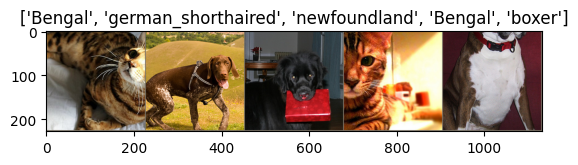

In [22]:
inputs_try, labels_try = next(iter(loader_valid))
out = torchvision.utils.make_grid(inputs_try)
imshow(out,title=[dset_classes[x] for x in labels_try])


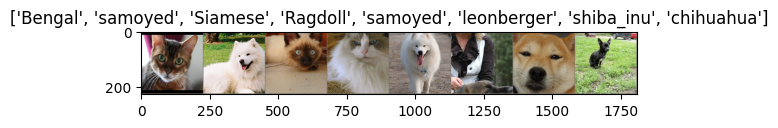

In [23]:
inputs,classes  = next(iter(loader_train))
n_images = 8

out = torchvision.utils.make_grid(inputs[:n_images])
imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [24]:
model_vgg = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 124MB/s]


In [25]:
inputs_try, labels_try = inputs_try.to(device), labels_try.to(device)
model_vgg = model_vgg.to(device)

In [26]:
outputs_try = model_vgg(inputs_try)

In [27]:
outputs_try.shape

torch.Size([5, 1000])

In [28]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
for param in model_vgg.parameters():
  param.requires_grad = False

model_vgg.classifier._modules['6'] = nn.Linear(4096,37)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim=1)


In [30]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
  (7): LogSoftmax(dim=1)
)


In [31]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

In [40]:
def train_model(model, dataloader, size,epochs=1,optimizer = None):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    for inputs, classes in dataloader:
      inputs = inputs.to(device)
      classes = classes.to(device)
      model = model.to(device)
      outputs = model(inputs)
      loss = criterion(outputs,classes)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      _,preds = torch.max(outputs.data,1)
      #stats
      running_loss+=loss.data.item()
      running_corrects+=torch.sum(preds == classes.data)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_acc))

In [41]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['train'],epochs=4,optimizer=optimizer_vgg)

Loss: 0.0304 Acc: 0.5932
Loss: 0.0248 Acc: 0.6951
Loss: 0.0211 Acc: 0.7481
Loss: 0.0185 Acc: 0.7856
CPU times: user 42.6 s, sys: 4.22 s, total: 46.8 s
Wall time: 1min 35s


In [42]:
def test_model(model,dataloader,size):
  model.eval()
  predictions = np.zeros(size)
  all_classes = np.zeros(size)
  all_proba = np.zeros((size,37))
  i = 0
  running_loss = 0.0
  running_corrects = 0
  for inputs,classes in dataloader:
    inputs = inputs.to(device)
    classes = classes.to(device)
    model = model.to(device)
    outputs = model(inputs)
    loss = criterion(outputs,classes)
    _,preds = torch.max(outputs.data,1)
    #stats
    running_loss+=loss.data.item()
    running_corrects+=torch.sum(preds == classes.data)
    predictions[i:i+len(classes)] = preds.to('cpu').numpy()
    all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
    all_proba[i:i+len(classes)] = outputs.data.to('cpu').numpy()
    i+=len(classes)
  epoch_loss = running_loss / size
  epoch_acc = running_corrects.data.item()/ size
  print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_acc))
  return predictions,all_proba,all_classes

In [43]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size =dset_sizes['test'] )

Loss: 0.2096 Acc: 0.8493


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


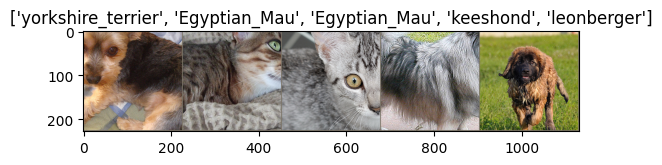

In [44]:
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [45]:
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))

tensor([[0.0201, 0.0145, 0.0091, 0.0100, 0.0050, 0.0062, 0.0111, 0.0048, 0.0056,
         0.0093, 0.0135, 0.0111, 0.0049, 0.0089, 0.0078, 0.0482, 0.0072, 0.0770,
         0.0513, 0.0226, 0.0068, 0.0075, 0.0984, 0.0214, 0.0208, 0.0097, 0.0294,
         0.0110, 0.0580, 0.0115, 0.0056, 0.0061, 0.0121, 0.0183, 0.0093, 0.0362,
         0.2896],
        [0.0439, 0.2017, 0.0129, 0.0220, 0.0356, 0.2968, 0.1411, 0.0239, 0.0389,
         0.0426, 0.0150, 0.0118, 0.0022, 0.0026, 0.0052, 0.0054, 0.0041, 0.0045,
         0.0061, 0.0096, 0.0073, 0.0019, 0.0075, 0.0048, 0.0035, 0.0030, 0.0028,
         0.0033, 0.0027, 0.0045, 0.0050, 0.0029, 0.0054, 0.0056, 0.0030, 0.0024,
         0.0085],
        [0.1105, 0.0486, 0.0181, 0.0230, 0.2133, 0.1860, 0.0743, 0.0246, 0.0345,
         0.1455, 0.0199, 0.0401, 0.0017, 0.0026, 0.0019, 0.0035, 0.0020, 0.0035,
         0.0028, 0.0035, 0.0029, 0.0018, 0.0039, 0.0014, 0.0021, 0.0011, 0.0013,
         0.0009, 0.0016, 0.0031, 0.0018, 0.0023, 0.0022, 0.0054, 0.0030, 

In [46]:
vals_try, preds_try = torch.max(outputs.data,1)

In [49]:
preds_try

tensor([36,  5,  4, 24, 25], device='cuda:0')

In [50]:
classes[:n_images]

tensor([36,  5,  5, 24, 25])

In [51]:
torch.exp(vals_try)

tensor([0.2896, 0.2968, 0.2133, 0.1416, 0.4785], device='cuda:0')

In [52]:
def preconvfeat(dataloader):
  conv_features = []
  labels_list = []
  for data in dataloader:
    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    x = model_vgg.features(inputs)
    conv_features.extend(x.data.cpu().numpy())
    labels_list.extend(labels.data.cpu().numpy())
  conv_features = np.concatenate([ [feat] for feat in conv_features])
  return (conv_features,labels_list)



In [57]:
conv_feat_train,labels_train = preconvfeat(loader_train)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [58]:
conv_feat_train.shape

(3680, 512, 7, 7)

In [55]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CPU times: user 17.1 s, sys: 1.63 s, total: 18.8 s
Wall time: 31 s


In [56]:
conv_feat_valid.shape

(3669, 512, 7, 7)

In [61]:
dtype = torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)


In [62]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['train'],epochs=80,optimizer=optimizer_vgg)

Loss: 0.0086 Acc: 0.7924
Loss: 0.0082 Acc: 0.8000
Loss: 0.0078 Acc: 0.8076
Loss: 0.0075 Acc: 0.8179
Loss: 0.0072 Acc: 0.8223
Loss: 0.0069 Acc: 0.8274
Loss: 0.0068 Acc: 0.8299
Loss: 0.0065 Acc: 0.8359
Loss: 0.0063 Acc: 0.8337
Loss: 0.0062 Acc: 0.8486
Loss: 0.0060 Acc: 0.8467
Loss: 0.0059 Acc: 0.8443
Loss: 0.0057 Acc: 0.8405
Loss: 0.0057 Acc: 0.8486
Loss: 0.0055 Acc: 0.8421
Loss: 0.0054 Acc: 0.8530
Loss: 0.0053 Acc: 0.8633
Loss: 0.0052 Acc: 0.8590
Loss: 0.0051 Acc: 0.8611
Loss: 0.0051 Acc: 0.8603
Loss: 0.0050 Acc: 0.8554
Loss: 0.0048 Acc: 0.8647
Loss: 0.0047 Acc: 0.8707
Loss: 0.0048 Acc: 0.8595
Loss: 0.0047 Acc: 0.8709
Loss: 0.0047 Acc: 0.8622
Loss: 0.0046 Acc: 0.8685
Loss: 0.0045 Acc: 0.8731
Loss: 0.0044 Acc: 0.8739
Loss: 0.0044 Acc: 0.8780
Loss: 0.0043 Acc: 0.8764
Loss: 0.0043 Acc: 0.8750
Loss: 0.0042 Acc: 0.8783
Loss: 0.0042 Acc: 0.8745
Loss: 0.0042 Acc: 0.8785
Loss: 0.0041 Acc: 0.8769
Loss: 0.0041 Acc: 0.8774
Loss: 0.0040 Acc: 0.8812
Loss: 0.0040 Acc: 0.8785
Loss: 0.0040 Acc: 0.8818


In [63]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

In [64]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])


Loss: 0.0034 Acc: 0.8874


In [65]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(37);
    plt.xticks(tick_marks, dset_classes, rotation=90);
    plt.yticks(tick_marks, dset_classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

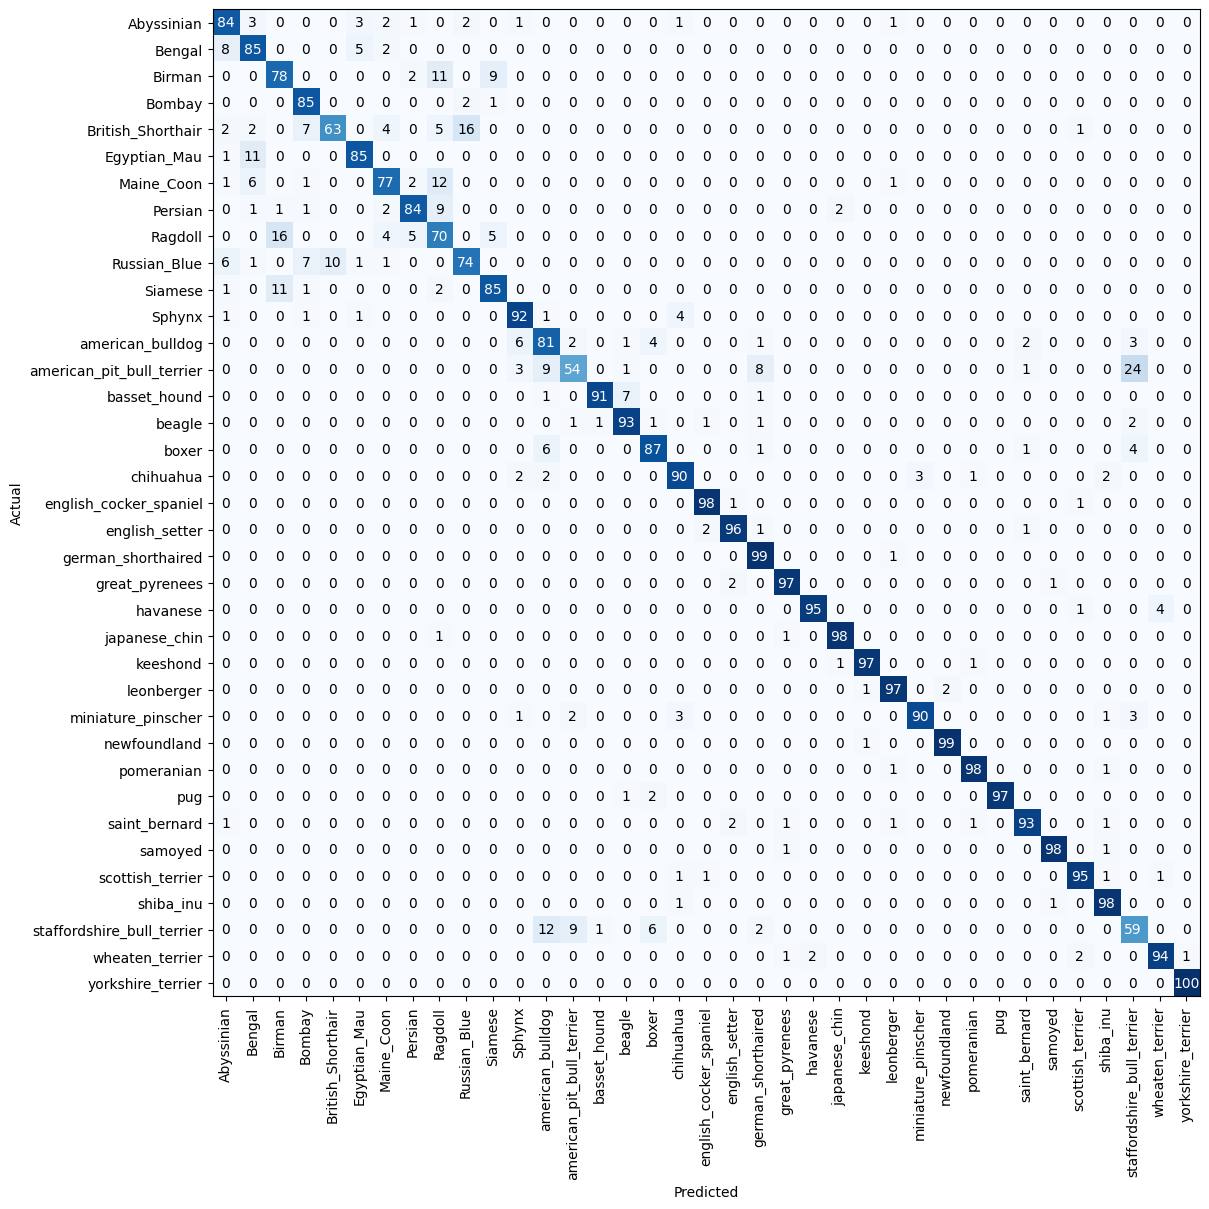

In [66]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

In [67]:
model_resnet = models.resnet34(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 102MB/s]


In [68]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [70]:
model_resnet.eval()
for param in model_resnet.parameters():
  param.requires_grad = False

model_resnet.fc = nn.Linear(512,37)

In [73]:
model_resnet_lsm = nn.Sequential(model_resnet,torch.nn.LogSoftmax(dim=1))

In [74]:
print(model_resnet_lsm)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [75]:
inputs_try, labels_try = inputs_try.to(device), labels_try.to(device)
model_resnet_lsm = model_resnet_lsm.to(device)
outputs_try = model_resnet_lsm(inputs_try)

In [76]:
outputs_try.shape

torch.Size([5, 37])

In [77]:
print(model_resnet_lsm[0].fc)

Linear(in_features=512, out_features=37, bias=True)


In [79]:
lr = 0.001
optimizer_resnet = torch.optim.SGD(model_resnet_lsm[0].fc.parameters(),lr=lr)

In [80]:
%%time
train_model(model_resnet_lsm,loader_train,size=dset_sizes['train'],epochs=30,optimizer=optimizer_resnet)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss: 0.0574 Acc: 0.0568
Loss: 0.0539 Acc: 0.0976
Loss: 0.0512 Acc: 0.1587
Loss: 0.0489 Acc: 0.2399
Loss: 0.0467 Acc: 0.3174
Loss: 0.0446 Acc: 0.4011
Loss: 0.0427 Acc: 0.4603
Loss: 0.0408 Acc: 0.5092
Loss: 0.0391 Acc: 0.5682
Loss: 0.0374 Acc: 0.6052
Loss: 0.0358 Acc: 0.6380
Loss: 0.0344 Acc: 0.6649
Loss: 0.0330 Acc: 0.6867
Loss: 0.0316 Acc: 0.7043
Loss: 0.0304 Acc: 0.7152
Loss: 0.0293 Acc: 0.7310
Loss: 0.0283 Acc: 0.7416
Loss: 0.0273 Acc: 0.7590
Loss: 0.0264 Acc: 0.7658
Loss: 0.0254 Acc: 0.7793
Loss: 0.0247 Acc: 0.7815
Loss: 0.0239 Acc: 0.7927
Loss: 0.0231 Acc: 0.7992
Loss: 0.0225 Acc: 0.8057
Loss: 0.0219 Acc: 0.8106
Loss: 0.0213 Acc: 0.8209
Loss: 0.0207 Acc: 0.8228
Loss: 0.0202 Acc: 0.8226
Loss: 0.0198 Acc: 0.8285
Loss: 0.0192 Acc: 0.8351
CPU times: user 1min 14s, sys: 32.6 s, total: 1min 47s
Wall time: 7min 38s


In [81]:
model_resnet_lsm.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [82]:
%%time
predictions, all_proba, all_classes = test_model(model_resnet_lsm,loader_valid,size=dset_sizes['test'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss: 0.2500 Acc: 0.7869
CPU times: user 9.28 s, sys: 1.22 s, total: 10.5 s
Wall time: 18.5 s


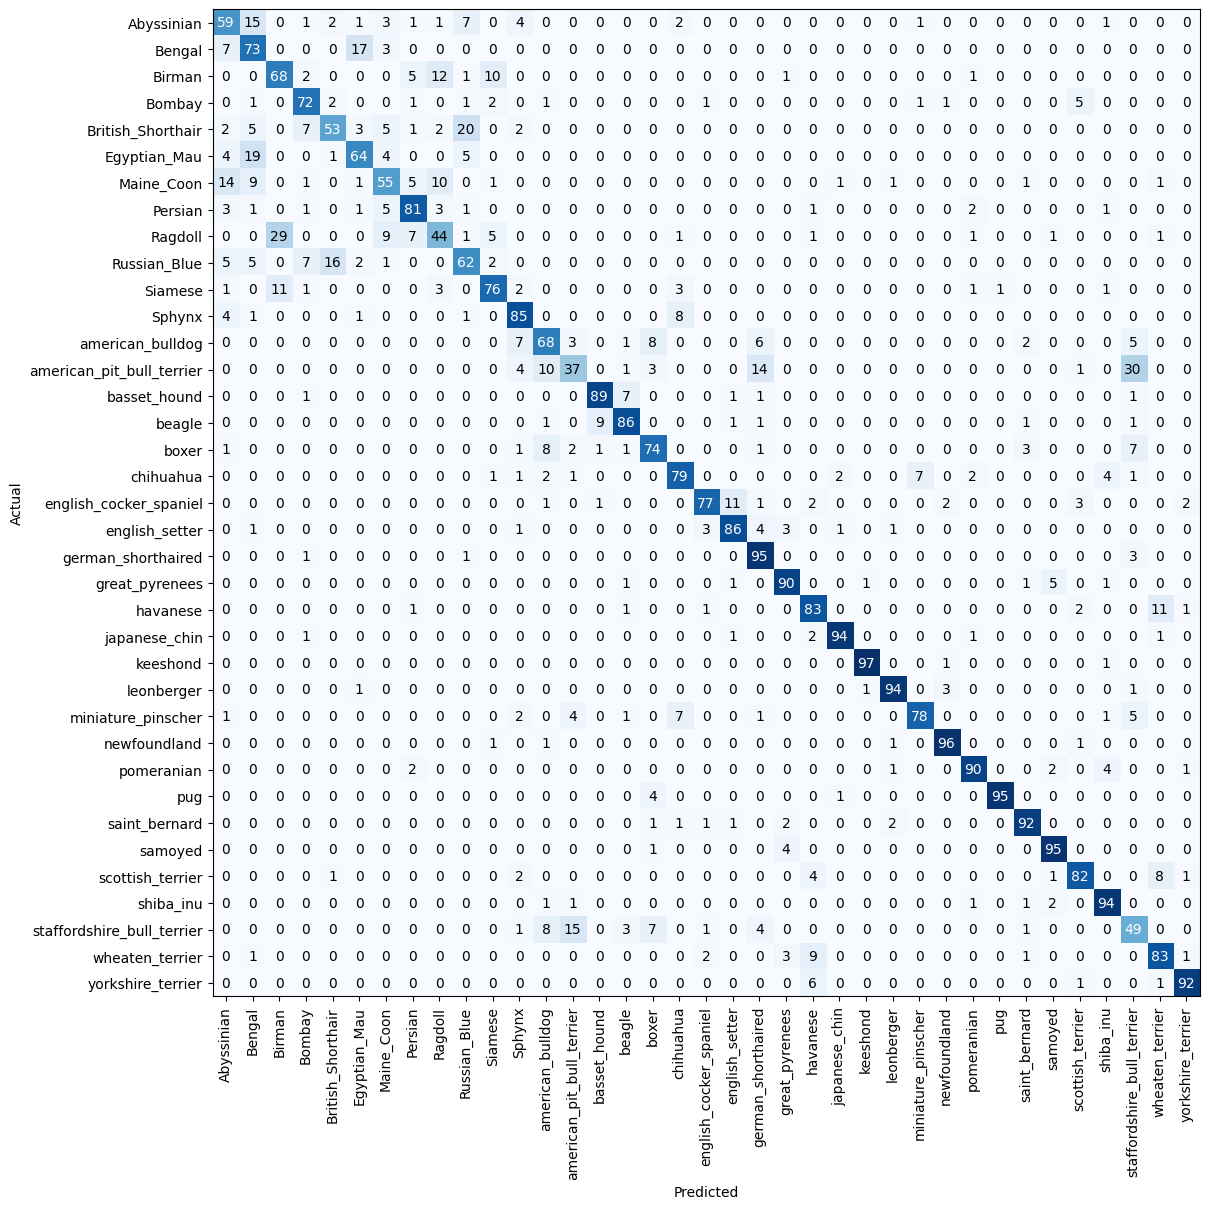

In [83]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

In [1]:
def preconvfeat(dataloader):
  conv_features = []
  labels_list = []
  for data in dataloader:
    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    x = model_resnet_lsm(inputs)
    conv_features.extend(x.data.cpu().numpy())
    labels_list.extend(labels.data.cpu().numpy())
  conv_features = np.concatenate([ [feat] for feat in conv_features])
  return (conv_features,labels_list)


In [ ]:
conv_feat_train,labels_train = preconvfeat(loader_train)
conv_feat_valid,labels_valid = preconvfeat(loader_valid)